# Example: PyRayHF Spherical Gradient Raytracing

### Background: Ray Equations in Spherical Geometry

In spherical geometry, rays are described in $(r, φ)$ coordinates:

- **$r$** = Earth radius + altitude [km]
- **$φ$** = surface arc angle [rad]
- **$v = (v_r, v_φ)$** = unit tangent vector
- **$s$** = arc length [km]
- **$n(r, φ)$** = $μ$ (phase index)

The ray equations become:
$$
dr/ds = v_r
$$
$$
dφ/ds = v_φ / r
$$
$$
dv_r/ds = (∂n/∂r - (∇n·v) v_r)/n + (v_φ^2)/r
$$
$$
dv_φ/ds = ((∂n/∂φ)/r - (∇n·v) v_φ)/n - (v_r v_φ)/r
$$


Here the geometry includes Earth curvature explicitly, making this method essential for long-range HF raytracing.

---

### Specifics in PyRayHF

- Geometry (bending) uses the **phase index $μ$**
- Group delay integrates the **group index $μ'$** (mup)f provided via `mup_func`
- Refractive index gradients $(∂μ/∂r, ∂μ/∂φ)$ are provided by `build_refractive_index_interpolator_rphi`
- Termination conditions stop the ray when it:
  - Hits the ground $(r = R_E + z_{ground})$
  - Leaves the radial or azimuthal bounds
  - Exceeds maximum arc length

This method is the most realistic in PyRayHF since it accounts for **curved-Earth geometry** while allowing for horizontally varying ionospheres.


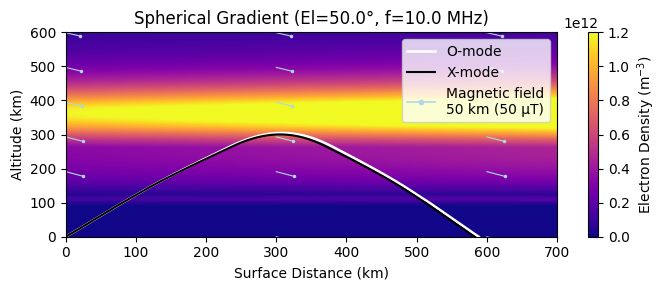

--------------------------------------------------
Spherical Gradient Raytracing O-mode:
--------------------------------------------------
Group Path (km):  874.2232355631913
Group delay (sec):  0.0033770723982179483
Ground Range (km):  588.3465456003439
x midpoint (km):  297.37116125392157
z midpoint (km):  303.81553025409994
--------------------------------------------------
Spherical Gradient Raytracing X-mode:
--------------------------------------------------
Group Path (km):  862.7170168380745
Group delay (sec):  0.0033747468544307936
Ground Range (km):  582.2786227727071
x midpoint (km):  296.0997066304728
z midpoint (km):  299.59050369026863
--------------------------------------------------
Elapsed time (sec):  2.433392209932208
--------------------------------------------------


In [2]:
#!/usr/bin/env python
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from PyRayHF.library import constants
from PyRayHF.library import find_X, find_Y, find_mu_mup
from PyRayHF.library import build_mup_function
from PyRayHF.library import build_refractive_index_interpolator_spherical
from PyRayHF.library import trace_ray_spherical_gradient
import time

# Directory on your local machine where to save the figures
local_dir = '/Users/vmakarevich/Documents/GitHub/PyRayHF/docs/figures/'

# Load an ionospheric profile
# See Example_Generate_Input_Arrays for how to create this input file using
# PyIRI.
file_open = 'Example_input.p'
input_arrays = pickle.load(open(file_open, 'rb'))
alt_km = input_arrays["alt"]
Ne = input_arrays["den"]
Babs = input_arrays["bmag"]
bpsi = input_arrays["bpsi"]

# Ensure ground level is included
h_ground = 0
if alt_km[0] > h_ground:
    Ne0 = np.interp(h_ground, alt_km, Ne)
    Babs0 = np.interp(h_ground, alt_km, Babs)
    bpsi0 = np.interp(h_ground, alt_km, bpsi)
    alt_km = np.insert(alt_km, 0, h_ground)
    Ne = np.insert(Ne, 0, Ne0)
    Babs = np.insert(Babs, 0, Babs0)
    bpsi = np.insert(bpsi, 0, bpsi0)

# Define inputs
elevation_deg = 50.
f0_Hz = 10e6

# Create 2D density grid (Ne assumed horizontally uniform)
nx = 500
xmax = 1000
x_grid = np.linspace(0, xmax, nx)
z_grid = alt_km
Xg, Zg = np.meshgrid(x_grid, z_grid)
Ne_grid = np.tile(Ne[:, np.newaxis], (1, nx))
Babs_grid = np.tile(Babs[:, np.newaxis], (1, nx))
bpsi_grid = np.tile(bpsi[:, np.newaxis], (1, nx))

# Add some gradient to it
Ne_gradient = Ne_grid * (1.0 - 0.1 * (Xg / Xg.max()))

# Start the timer to time the code
start_time = time.perf_counter()

# Calculate plasma parameters
X = find_X(Ne_gradient, f0_Hz)
Y = find_Y(f0_Hz, Babs_grid)

# O-mode
mode = "O"
mu, mup = find_mu_mup(X, Y, bpsi_grid, mode)
mup = np.where((mup < 1e-3) | np.isnan(mup), np.nan, mup)

# Build a function for spherical interpolation of mup
mup_func_spherical = build_mup_function(mup_field=mup,
                                        x_grid=x_grid,
                                        z_grid=z_grid,
                                        geometry="spherical")

# Build interpolator from spherical μ grid
n_and_grad_spherical = build_refractive_index_interpolator_spherical(z_grid,
                                                                     x_grid,
                                                                     mu)

# Raytrace
result_O = trace_ray_spherical_gradient(n_and_grad_rphi=n_and_grad_spherical,
                                        x0_km=0.0,
                                        z0_km=0.0,
                                        elevation_deg=elevation_deg,
                                        s_max_km=4000.,
                                        mup_func=mup_func_spherical)

# Stop the timer
end_time = time.perf_counter()
# Calculate and print the elapsed time
elapsed_time = end_time - start_time

# X-mode
mode = "X"
mu, mup = find_mu_mup(X, Y, bpsi_grid, mode)
mup = np.where((mup < 1e-3) | np.isnan(mup), np.nan, mup)

# Build a function for spherical interpolation of mup
mup_func_spherical = build_mup_function(mup_field=mup,
                                        x_grid=x_grid,
                                        z_grid=z_grid,
                                        geometry="spherical")

# Build interpolator from spherical μ grid
n_and_grad_spherical = build_refractive_index_interpolator_spherical(z_grid,
                                                                     x_grid,
                                                                     mu)

# Raytrace
result_X = trace_ray_spherical_gradient(n_and_grad_rphi=n_and_grad_spherical,
                                        x0_km=0.0,
                                        z0_km=0.0,
                                        elevation_deg=elevation_deg,
                                        s_max_km=4000.,
                                        mup_func=mup_func_spherical)

# Plot results
fig, ax = plt.subplots(1, 1, figsize=(7, 3))
ax.set_xlim(0, 700)
ax.set_ylim(0, 600)
ax.set_facecolor("lightgray")
ax.set_ylabel('Altitude (km)')
ax.set_xlabel('Surface Distance (km)')

# --- Electron density background
vmin, vmax = 0, 1.2e12
color_ticks = np.arange(vmin, vmax + 2e11, 2e11)
pc = ax.pcolormesh(Xg, Zg, Ne_gradient, shading='auto',
                   cmap='plasma', vmin=vmin, vmax=vmax)

# --- Magnetic field visualization (simple line segments with dots)
# Babs is in Tesla (≈3–6e-5), convert to relative visual length
B_scale = 1e6  # empirical scaling factor to make lines a few tens of km long
Bx = Babs * np.sin(np.deg2rad(bpsi)) * B_scale
Bz = -Babs * np.cos(np.deg2rad(bpsi)) * B_scale

# Subsample altitudes for clarity
step_z = max(1, len(alt_km)//5)
z_sample = alt_km[::step_z]
Bx_sample = Bx[::step_z]
Bz_sample = Bz[::step_z]

# Repeat horizontally every 300 km
x_spacing = 300  # km
x_repeat = np.arange(0, ax.get_xlim()[1], x_spacing)

for x_offset in x_repeat:
    for zs, bx, bz in zip(z_sample, Bx_sample, Bz_sample):
        xs, xe = x_offset, x_offset + bx
        ze = zs + bz
        ax.plot([xs, xe], [zs, ze], color='lightblue', lw=0.8)
        ax.plot(xe, ze, 'o', color='lightblue', ms=1.5)

# --- Plot the actual ray paths
line_O, = ax.plot(result_O['x'], result_O['z'], c='white', lw=1.8, label='O-mode')
line_X, = ax.plot(result_X['x'], result_X['z'], c='black', lw=1.5, label='X-mode')

# --- Add custom magnetic field legend handle
B_ref = 50e-6  # 50 µT reference
line_length_km = B_ref * B_scale  # visible line length
legend_line = Line2D([0, 1], [0, 0], color='lightblue', lw=1.2,
                     marker='o', markersize=3,
                     label=f'Magnetic field\n{line_length_km:.0f} km (50 µT)')

# --- Labels, colorbar, legend
ax.set_title(f"Spherical Gradient (El={elevation_deg:.1f}°, f={f0_Hz/1e6:.1f} MHz)")
plt.colorbar(pc, label='Electron Density (m$^{-3}$)', ax=ax, ticks=color_ticks)

ax.legend(handles=[line_O, line_X, legend_line], loc='upper right')

plt.tight_layout()
plt.savefig(local_dir + 'Spherical_Gradient.png',
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Print diagnostics
print('--------------------------------------------------')
print('Spherical Gradient Raytracing O-mode:')
print('--------------------------------------------------')
print('Group Path (km): ', result_O['group_path_km'])
print('Group delay (sec): ', result_O['group_delay_sec'])
print('Ground Range (km): ', result_O['ground_range_km'])
print('x midpoint (km): ', result_O['x_midpoint'])
print('z midpoint (km): ', result_O['z_midpoint'])

print('--------------------------------------------------')
print('Spherical Gradient Raytracing X-mode:')
print('--------------------------------------------------')
print('Group Path (km): ', result_X['group_path_km'])
print('Group delay (sec): ', result_X['group_delay_sec'])
print('Ground Range (km): ', result_X['ground_range_km'])
print('x midpoint (km): ', result_X['x_midpoint'])
print('z midpoint (km): ', result_X['z_midpoint'])

print('--------------------------------------------------')
print('Elapsed time (sec): ', elapsed_time)
print('--------------------------------------------------')